# Project 1 - Sentiment Classification

In this project, you will conduct a sentiment analysis task.
You will build a model to predict the scores (a.k.a. stars, from 1-5) of each review.
For each review, you are given a piece of text as well as some other features (Explore yourself!).
You can consider the predicted variables to be categorical, ordinal or numerical.

DDL: *April 6, 2021*
- *March 23, 2021* release the validation score of weak baseline--60.2%
- *March 30, 2021* release the validation score of strong baseline

Submission: Each team leader is required to submit the groupNo.zip file in the canvas. It shoud contain 
- `pre.csv` Predictions on test data (please make sure you can successfully evaluate your validation predictions on the validation data with the help of evaluate.py)
- report (1-2 pages of pdf)
- code (Frameworks and programming languages are not restricted.)

We will check your report with your code and the accuracy.

| Grade | Classifier (80%)                                                   | Report (20%)                      |
|-------|--------------------------------------------------------------------|-----------------------------------|
| 50%   | example code in tutorials or in Project 1 without any modification | submission                        |
| 60%   | an easy baseline that most students can outperform                 | algorithm you used                |
| 80%   | a competitive baseline that about half students can surpass        | detailed explanation              |
| 90%   | a very competitive baseline without any special mechanism          | detailed explanation and analysis, such as explorative data analysis and ablation study |
| 100%  | a very competitive baseline with at least one mechanism            | excellent ideas, detailed explanation and solid analysis |


## Instruction Content

1. Load & Dump the data
    1. Load the data
    1. Dump the data
1. Preprocessing
    1. Text data processing recap
    1. Explorative data analysis
1. Learning Baselines


## 1.Packages Preparation

In [17]:
import os
import nltk
import math
import pandas as pd
import numpy as np

from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, \
    confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import keras as K

from keras.optimizers import SGD
# from keras import metricsnmmnbn

# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Activation, Input, \
#    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords = set(stopwords.words('english'))
ps = PorterStemmer()


import spacy
nlp = spacy.load('en_core_web_sm')
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm

### Data Loader

Here is a function to load your data, remember put the dataset in the `data_2021_spring` folder.


In [38]:
def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df["business_id"], df["text"], df["stars"]

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)["stars"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "stars"]
    df.to_csv(file_name, index=False)

In [19]:
# def load_data(split_name='train', columns=['text', 'stars']):
#     try:
#         print(f"select [{', '.join(columns)}] columns from the {split_name} split")
#         df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
#         df = df.loc[:,columns]
#         print("succeed!")
#         return df
#     except:
#         print("Failed, then try to ")
#         print(f"select all columns from the {split_name} split")
#         df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
#         return df

In [21]:
# train_df = load_data('train', columns=['text',\
#                                        'stars','business_id','cool',\
#                                        'date','funny','review_id','useful','user_id'])

In [22]:
#Items of dataset:
    #business_id
    #cool: whether it's cool
    #date: public date
    #funny: whether it's funny
    #review_id
    #text： content
    #useful: whether it's useful
    #user_id
#load 10000 sentences are training set
train_df.head(0)

,text,stars,business_id,cool,date,funny,review_id,useful,user_id


In [24]:
#Prepare the test set
# test_df = load_data('test')
# test_df.head(0)

#### Below is the way to write dataset into a .csv file, i.e. the format of submission files.

In [ ]:
#construct a dataset with genuine review_id and randomized stars
# random_ans = pd.DataFrame(data={
#     'review_id': test_df['review_id'],
#     'stars': np.random.randint(0, 6, size=len(test_df))
# })

In [ ]:
# random_ans.head()

In [ ]:
#write this dataset into a .csv file, which should be the format of our submission
# group_number = -1
# random_ans.to_csv(f'{group_number}-random_ans.csv', index=False)

## 2.Feature Extractor

Preprocessing and feature engineering

In [25]:
#return the lower cases of the texts
def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")

#tokenize the texts
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]



def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

In [26]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    # .most_common(): List the n most common elements and their counts from the most common to the least.
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        try:
            vector[i] = feats_dict[f]
        except KeyError:
            vector[i] = 1
    return vector

In [ ]:
# test_df['tokens'] = test_df['text'].map(tokenize).map(filter_stopwords).map(lower)
# print(test_df['tokens'].head().to_string())

In [ ]:
# fmt = "{:10s},\t " * 8

# for token in doc:
#     print(fmt.format(token.text, token.lemma_, token.pos_, token.dep_,
#             token.shape_, str(token.is_alpha), str(token.is_stop), 
#                      str(list(token.children))))

## 3.Classifier

#### CNN

In [27]:
def build_CNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              kernel_sizes, num_filters, num_mlp_layers,
              padding="valid",
              strides=1,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param kernel_sizes: the kernel sizes of convolutional layers, type: list
    :param num_filters: the number of filters for each kernel, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param padding: the padding method in convolutional layers, type: str
    :param strides: the strides in convolutional layers, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a CNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # convolutional layers document: https://keras.io/layers/convolutional
    # pooling layers document: https://keras.io/layers/pooling/
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    emb = Embedding(input_dim=vocab_size, output_dim=embedding_size)(x)
    
    ################################
    ########### Conv-Pool ##########
    ################################
    # convolutional and pooling layers
    cnn_results = list()
    for kernel_size in kernel_sizes:
        # add convolutional layer
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, strides=strides)(emb)
        # add batch normalization layer
        if batch_norm:
            conv = BatchNormalization()(conv)
        # add activation
        conv = Activation(activation)(conv)
        # add max-pooling
        maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
        cnn_results.append(Flatten()(maxpool))
    
    ################################
    ##### Fully Connected Layer ####
    ################################
    h = Concatenate()(cnn_results) if len(kernel_sizes) > 1 else cnn_results[0]
    h = Dropout(dropout_rate, seed=0)(h)
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [40]:
train_file = "data_2021_spring/train.csv"
val_file = "data_2021_spring/valid.csv"
ans_file = "data_2021_spring/ans.csv"
pred_file = "data_2021_spring/pred.csv"
min_freq = 3

# load data
train_ids, train_texts, train_labels = load_data(train_file)
val_ids, val_texts, val_labels = load_data(val_file)
#  = load_labels(val_file)

# extract features
train_tokens = [tokenize(text) for text in train_texts]
val_tokens = [tokenize(text) for text in val_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
val_stemmed = [stem(tokens) for tokens in val_tokens]

train_feats = [filter_stopwords(tokens) for tokens in train_stemmed]
val_feats = [filter_stopwords(tokens) for tokens in val_stemmed]

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 9165


Text(0, 0.5, 'Cumulative Numbers')

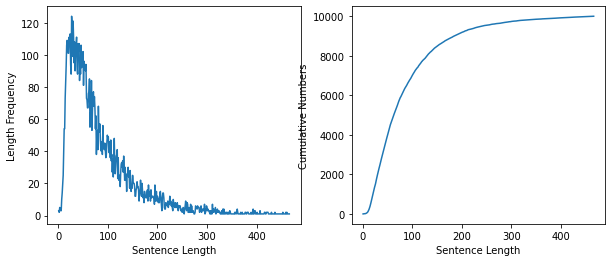

In [41]:
plt.figure(figsize=(10,4))
len_cnt = Counter([len(feats) for feats in train_feats])
len_key = sorted(len_cnt)
plt.subplot(1,2,1)
plt.plot(range(1, len(len_key)+1),
         [len_cnt[l] for l in len_key])
plt.xlabel("Sentence Length")
plt.ylabel("Length Frequency")

plt.subplot(1,2,2)
plt.plot(range(1, len(len_key)+1),
         np.cumsum([len_cnt[l] for l in len_key]))
plt.xlabel("Sentence Length")
plt.ylabel("Cumulative Numbers")

In [42]:
max_len = 200

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
val_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in val_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
val_label_matrix = keras.utils.to_categorical(val_labels-1, num_classes=num_classes)

In [43]:
os.makedirs("models", exist_ok=True)
model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[1,2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu",
                  dropout_rate=0.5, l2_reg=0.005, batch_norm=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

np.random.seed(0)
tf.random.set_seed(0)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(test_feats_matrix, test_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 1s 38ms/step - loss: 1.6803 - accuracy: 0.5740
training loss: 0.18391799926757812 training accuracy 0.9571999907493591
validation loss: 1.6802531480789185 validation accuracy 0.5740000009536743


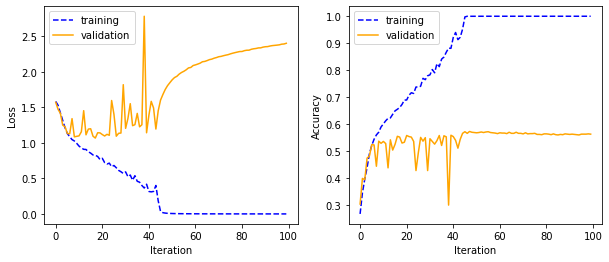

In [45]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_loss"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_accuracy"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Draft

In [ ]:
train_df = load_data('train')[:5000]
valid_df = load_data('valid')

In [ ]:
x_train = train_df['text']
y_train = train_df['stars']

In [ ]:
tfidf = TfidfVectorizer(tokenizer=tokenize)
lr = LogisticRegression()
steps = [('tfidf', tfidf),('lr', lr)]
pipe = Pipeline(steps)
print(pipe)

In [ ]:
pipe.fit(x_train, y_train)

In [ ]:
x_valid = valid_df['text']
y_valid = valid_df['stars']
y_pred = pipe.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

In [ ]:
train_text = train_df['text'].map(tokenize).map(filter_stopwords).map(stem)
valid_text = valid_df['text'].map(tokenize).map(filter_stopwords).map(stem)

In [ ]:
word2id = {}
for tokens in train_text:
    for t in tokens:
        if not t in word2id:
            word2id[t] = len(word2id)
word2id['<pad>'] = len(word2id)

In [ ]:
def texts_to_id_seq(texts, padding_length=500):
    records = []
    for tokens in texts:
        record = []
        for t in tokens:
            record.append(word2id.get(t, len(word2id)))
        if len(record) >= padding_length:
            records.append(record[:padding_length])
        else:
            records.append(record + [word2id['<pad>']] * (padding_length - len(record)))
    return records

In [ ]:
train_seqs = texts_to_id_seq(train_text)
valid_seqs = texts_to_id_seq(valid_text)

In [ ]:
class MyDataset(Dataset):
    
    def __init__(self, seq, y):
        assert len(seq) == len(y)
        self.seq = seq
        self.y = y-1
    
    def __getitem__(self, idx):
        return np.asarray(self.seq[idx]), self.y[idx]

    def __len__(self):
        return len(self.seq)

In [ ]:
batch_size = 16

train_loader = DataLoader(MyDataset(train_seqs, y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(MyDataset(valid_seqs, y_valid), batch_size=batch_size)

In [ ]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=len(word2id)+1, embedding_dim=64)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1),
            nn.MaxPool1d(kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1),
            nn.MaxPool1d(kernel_size=3, stride=1),
            nn.Dropout(0.5)
        )
        self.linear = nn.Linear(64, 5)
    
    def forward(self, x):
        x = self.embedding(x)
        x = torch.transpose(x, 1, 2)
        x = self.cnn(x)
        x = torch.max(x, dim=-1)[0]
        x = self.linear(x)
        return x

In [ ]:
model = mlp()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for e in range(1, 11):    
    print('epoch', e)
    model.train()
    total_acc = 0
    total_loss = 0
    total_count = 0
    with tqdm.tqdm(train_loader) as t:
        for x, y in t:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            total_acc += (logits.argmax(1) == y).sum().item()
            total_count += y.size(0)
            total_loss += loss.item()
            optimizer.step()
            t.set_postfix({'loss': total_loss/total_count, 'acc': total_acc/total_count})

    model.eval()
    y_pred = []
    y_true = []
    with tqdm.tqdm(valid_loader) as t:
        for x, y in t:
            logits = model(x)
            total_acc += (logits.argmax(1) == y).sum().item()
            total_count += len(y)
            y_pred += logits.argmax(1).tolist()
            y_true += y.tolist()
    print(classification_report(y_true, y_pred))
    print("\n\n")
    print(confusion_matrix(y_true, y_pred))